In [74]:
import env
import utilities
import pandas as pd


In [75]:
_zillow_query = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL
"""


In [76]:
zillow_df = acquire_zillow.acquire_zillow_df()

In [77]:
zillow_df.head(5)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1,1072280,10711877,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
2,1340933,10711888,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
3,1878109,10711910,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,2190858,10711923,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [13]:
zillow_df.sample(15)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
62023,415287,14397993,1.0,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059042e+13,0.107174,2017-08-28,Central,NaN,NaN,Forced air,Single Family Residential,NaN,NaN
31988,1438219,12166871,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037460e+13,-0.086570,2017-03-07,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
7885,763085,11030271,NaN,NaN,NaN,1.0,4.0,NaN,4.0,1.0,...,6.037122e+13,-0.013103,2017-05-23,NaN,NaN,NaN,Floor/Wall,Single Family Residential,NaN,NaN
27727,751378,11980652,1.0,NaN,NaN,1.0,0.0,NaN,8.0,1.0,...,6.037212e+13,0.135468,2017-08-28,Central,NaN,NaN,Central,Condominium,NaN,NaN
72787,1611325,17120696,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,6.111003e+13,-0.051898,2017-05-08,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
45596,367235,12855921,1.0,NaN,NaN,3.0,4.0,NaN,7.0,3.0,...,6.037502e+13,-0.043009,2017-05-26,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
36475,52134,12432217,NaN,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,6.037555e+13,0.314128,2017-06-22,NaN,NaN,NaN,Floor/Wall,Single Family Residential,NaN,NaN
2958,344675,10820198,NaN,NaN,NaN,2.0,4.0,NaN,4.0,2.0,...,6.037131e+13,0.137213,2017-02-10,NaN,NaN,NaN,Floor/Wall,Single Family Residential,NaN,NaN
5253,268121,10908229,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037143e+13,-0.074451,2017-04-19,Central,NaN,NaN,Central,Condominium,NaN,NaN
27323,1019704,11960087,NaN,NaN,NaN,2.0,4.0,NaN,4.0,2.0,...,6.037186e+13,0.048627,2017-05-19,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [14]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77575 entries, 0 to 77574
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77575 non-null  int64  
 1   parcelid                      77575 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77575 non-null  float64
 6   bedroomcnt                    77575 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49809 non-null  float64
 9   calculatedbathnbr             76960 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77375 non-null  float64
 13  f

In [38]:
zillow_df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,"77,575.00","77,575.00","25,006.00",206.00,50.00,"77,575.00","77,575.00",15.00,"49,809.00","76,960.00",...,"17,596.00",172.00,"77,460.00","77,574.00","77,575.00","77,573.00","77,570.00","2,900.00","77,328.00","77,575.00"
mean,"1,495,352.00","13,006,298.98",1.81,7.39,679.72,2.30,3.05,3.93,6.53,2.32,...,1.43,1.00,"189,281.45","490,144.70","2,016.00","301,145.30","5,995.82",14.09,"60,496,658,430,262.86",0.02
std,"860,970.27","3,478,020.75",2.97,2.73,689.70,1.00,1.14,0.26,1.72,0.98,...,0.54,0.00,"230,413.73","653,802.18",0.00,"492,728.73","7,628.87",2.18,"1,533,375,678,743.79",0.17
min,349.00,"10,711,855.00",1.00,2.00,38.00,0.00,0.00,3.00,1.00,1.00,...,1.00,1.00,44.00,"1,000.00","2,016.00",161.00,19.92,3.00,"60,371,011,101,000.00",-4.66
25%,"752,105.00","11,538,198.00",1.00,7.00,273.00,2.00,2.00,4.00,6.00,2.00,...,1.00,1.00,"84,182.00","206,898.50","2,016.00","85,293.00","2,712.63",14.00,"60,373,109,004,005.00",-0.02
50%,"1,498,195.00","12,530,531.00",1.00,7.00,515.00,2.00,3.00,4.00,6.00,2.00,...,1.00,1.00,"136,404.50","358,878.50","2,016.00","203,174.00","4,448.26",15.00,"60,376,032,001,020.00",0.01
75%,"2,240,715.00","14,211,235.50",1.00,7.00,796.50,3.00,4.00,4.00,8.00,3.00,...,2.00,1.00,"218,734.00","569,000.00","2,016.00","366,753.00","6,926.78",15.00,"60,590,423,251,007.00",0.04
max,"2,982,274.00","167,689,317.00",13.00,21.00,"3,560.00",18.00,16.00,4.00,12.00,18.00,...,6.00,1.00,"11,421,790.00","49,061,236.00","2,016.00","48,952,198.00","586,639.30",99.00,"483,030,105,084,015.00",5.26


In [39]:
#Prepare 
def drop_unnecessary_columns(zillow_df):
    """
    Takes in the zillow data frame and removes any columns deemed unnecessary or those that do not meet the population thresholds. Returns a       copy of the data frame without those columns.
    """
    df = zillow_df.copy()
    
    df = utils.handle_missing_values(df, .6, .4)
    drop_cols = ['id', 'parcelid', 'finishedsquarefeet12', 'fullbathcnt', 'propertylandusetypeid', 'heatingorsystemtypeid', 'censustractandblock', 'rawcensustractandblock', 'regionidzip', 'assessmentyear', 'regionidcounty', 'yearbuilt', 'roomcnt']
    
    return df.drop(columns=drop_cols)

def handle_missing_zillow_values(zillow_df):
    """
    Takes in the zillow data frame and fills the NaN values with either the mode or the median of the column. Returns a copy of the data frame     with the filled in values.
    """
    df = zillow_df.copy()
    
    df['buildingqualitytypeid'].fillna(value=8.0, inplace=True)    
    df['calculatedbathnbr'].fillna(value=2.0, inplace=True)
    df['calculatedfinishedsquarefeet'].fillna(value=1542, inplace=True)
    df['lotsizesquarefeet'].fillna(value=7205, inplace=True)
    df['propertyzoningdesc'].fillna(value="LAR1", inplace=True)
    df['regionidcity'].fillna(value=12447, inplace=True)
    df['regionidzip'].fillna(value=97319, inplace=True)
    df['unitcnt'].fillna(value=1, inplace=True)
    df['yearbuilt'].fillna(value=1970, inplace=True)
    df['structuretaxvaluedollarcnt'].fillna(value=136399.0, inplace=True)
    df['heatingorsystemdesc'].fillna(value='Central', inplace=True)
    df['taxamount'].fillna(value=4447.63, inplace=True)
    df['taxvaluedollarcnt'].fillna(value=358879, inplace=True)
    df['landtaxvaluedollarcnt'].fillna(value=203174, inplace=True)
    
    return df

def rename_zillow_columns(zillow_df):
    """
    Takes in the zillow data frame and renames the columns. Returns a copy of the data frame with the renamed columns.
    """
    df = zillow_df.copy()
    
    rename_dict = {'bathroomcnt' : 'bathrooms', 'bedroomcnt' : 'bedrooms', 'buildingqualitytypeid' : 'build_quality', 'calculatedbathnbr' : 'fractional_bathrooms', 'calculatedfinishedsquarefeet' : 'sqft', 'lotsizesquarefeet' : 'lot_size', 'propertycountylandusecode' : 'land_use_code', 'propertyzoningdesc' : 'zoning_desc', 'regionidcity' : 'city_id', 'unitcnt' : 'units', 'structuretaxvaluedollarcnt' : 'structure_tax_value', 'taxvaluedollarcnt' : 'tax_value', 'landtaxvaluedollarcnt' : 'land_tax_value', 'taxamount' : 'tax_amount', 'logerror' : 'error', 'transactiondate' : 'transaction_date', 'heatingorsystemdesc' : 'heat_system_desc', 'propertylandusedesc' : 'property_land_use_desc'}
    
    return df.rename(columns=rename_dict)

def encode_zillow_categoricals(zillow_df):
    """
    Takes in the zillow data frame and encodes the categorical variables. Returns a copy of the data frame with the encoded columns.
    """
    df = zillow_df.copy()

    fips_dummies = pd.get_dummies(df.fips, dummy_na=False, drop_first=True)
    heat_dummies = pd.get_dummies(df.heat_system_desc, dummy_na=False, drop_first=True)
    prop_use_dummies = pd.get_dummies(df.property_land_use_desc, dummy_na=False, drop_first=True)
    
    return pd.concat([df, fips_dummies, heat_dummies, prop_use_dummies], axis=1)

def add_zillow_features(zillow_df):
    """
    Takes in the zillow data frame and adds engineered features. Returns a copy of the dataframe with the new features.
    """
    df = zillow_df.copy()
    
    df['age'] = 2017 - df['yearbuilt']
    
    return df

def remove_zillow_outliers(zillow_df):
    """
    Takes in the zillow data frame and removes outliers above the determined upper bound. Returns a copy of the data frame with the outliers       removed.
    """
    df = zillow_df.copy()
    cont_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'error']

    for var in cont_vars:
        upper_bound, lower_bound = utils.generate_outlier_bounds(df, var, 3)  
        df = df[(df[var] > lower_bound) & (df[var] < upper_bound)]
    
    return df
    

In [15]:
utils.show_missing_value_stats_by_col(zillow_df)

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52569,0.677654
architecturalstyletypeid,77369,0.997345
basementsqft,77525,0.999355
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingclasstypeid,77560,0.999807
buildingqualitytypeid,27766,0.357925
calculatedbathnbr,615,0.007928


In [16]:
utils.show_missing_value_stats_by_row(zillow_df)

,num_rows,pct_cols_missing
num_cols_missing,,
23,2,0.338235
24,13,0.352941
25,24,0.367647
26,65,0.382353
27,316,0.397059
28,457,0.411765
29,5285,0.426471
30,3465,0.441176
31,9911,0.455882


In [17]:
drop_missing_zillow = utils.handle_missing_values(zillow_df.copy(), .6, .4)
drop_missing_zillow.head()

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,1087254,10711855,2.0,3.0,8.0,2.0,2107.0,2107.0,6037.0,2.0,...,249655.0,624139.0,2016.0,374484.0,7659.36,6.037113e+13,-0.007357,2017-07-07,Central,Single Family Residential
1,1072280,10711877,2.0,4.0,8.0,2.0,1882.0,1882.0,6037.0,2.0,...,253000.0,660000.0,2016.0,407000.0,8123.91,6.037113e+13,0.021066,2017-08-29,Central,Single Family Residential
2,1340933,10711888,2.0,4.0,8.0,2.0,1882.0,1882.0,6037.0,2.0,...,257591.0,542923.0,2016.0,285332.0,6673.24,6.037113e+13,0.077174,2017-04-04,Central,Single Family Residential
3,1878109,10711910,2.0,3.0,8.0,2.0,1477.0,1477.0,6037.0,2.0,...,57968.0,78031.0,2016.0,20063.0,1116.46,6.037113e+13,-0.041238,2017-03-17,Central,Single Family Residential
4,2190858,10711923,2.0,4.0,8.0,2.0,1918.0,1918.0,6037.0,2.0,...,167869.0,415459.0,2016.0,247590.0,5239.85,6.037113e+13,-0.009496,2017-03-24,Central,Single Family Residential


In [18]:
drop_missing_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77319 entries, 0 to 77573
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77319 non-null  int64  
 1   parcelid                      77319 non-null  int64  
 2   bathroomcnt                   77319 non-null  float64
 3   bedroomcnt                    77319 non-null  float64
 4   buildingqualitytypeid         49806 non-null  float64
 5   calculatedbathnbr             76938 non-null  float64
 6   calculatedfinishedsquarefeet  77315 non-null  float64
 7   finishedsquarefeet12          73905 non-null  float64
 8   fips                          77319 non-null  float64
 9   fullbathcnt                   76938 non-null  float64
 10  heatingorsystemtypeid         49570 non-null  float64
 11  latitude                      77319 non-null  float64
 12  longitude                     77319 non-null  float64
 13  l

In [19]:
drop_missing_zillow.shape

(77319, 34)

In [20]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingqualitytypeid,27513,0.355838
calculatedbathnbr,381,0.004928
calculatedfinishedsquarefeet,4,0.000052
finishedsquarefeet12,3414,0.044155
fips,0,0.000000
fullbathcnt,381,0.004928


In [21]:
drop_missing_zillow['buildingqualitytypeid'].value_counts()

8.0     14685
6.0     13501
4.0      9506
7.0      5980
9.0      2303
5.0      2099
11.0      933
3.0       335
10.0      313
12.0      116
1.0        26
2.0         9
Name: buildingqualitytypeid, dtype: int64

In [22]:
drop_missing_zillow['buildingqualitytypeid'].fillna(value=8.0, inplace=True)


In [23]:
drop_missing_zillow['buildingqualitytypeid'].value_counts()


8.0     42198
6.0     13501
4.0      9506
7.0      5980
9.0      2303
5.0      2099
11.0      933
3.0       335
10.0      313
12.0      116
1.0        26
2.0         9
Name: buildingqualitytypeid, dtype: int64

In [24]:
drop_missing_zillow['calculatedbathnbr'].median()


2.0

In [25]:
drop_missing_zillow['calculatedbathnbr'].fillna(value=2.0, inplace=True)



In [26]:
drop_missing_zillow['calculatedfinishedsquarefeet'].median()


1542.0

In [27]:
drop_missing_zillow['calculatedfinishedsquarefeet'].fillna(value=1542, inplace=True)


In [28]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)


,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingqualitytypeid,0,0.000000
calculatedbathnbr,0,0.000000
calculatedfinishedsquarefeet,0,0.000000
finishedsquarefeet12,3414,0.044155
fips,0,0.000000
fullbathcnt,381,0.004928


In [29]:
drop_cols = ['finishedsquarefeet12', 'fullbathcnt', 'propertylandusetypeid', 'heatingorsystemtypeid', 'censustractandblock']
drop_missing_zillow.drop(columns=drop_cols, inplace=True)

In [30]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingqualitytypeid,0,0.000000
calculatedbathnbr,0,0.000000
calculatedfinishedsquarefeet,0,0.000000
fips,0,0.000000
latitude,0,0.000000
longitude,0,0.000000


In [31]:
drop_missing_zillow['lotsizesquarefeet'].median()

7205.0

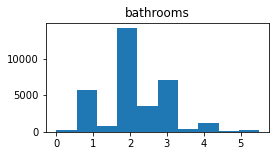

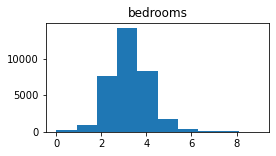

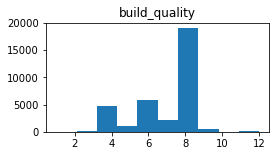

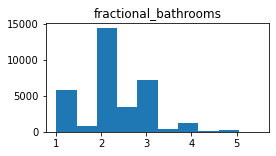

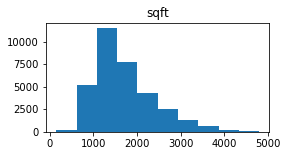

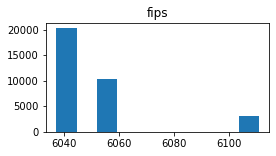

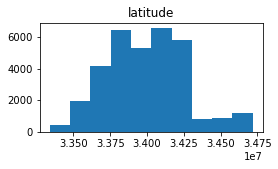

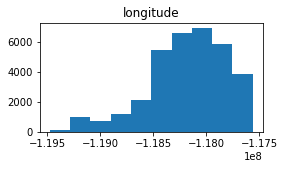

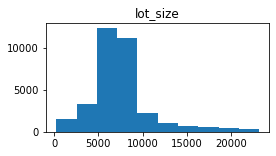

TypeError: '<=' not supported between instances of 'int' and 'str'

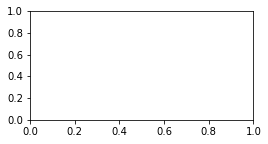

In [57]:
# What is the distribution of each of the variables?
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [32]:
drop_missing_zillow['lotsizesquarefeet'].fillna(value=7205, inplace=True)

In [33]:
drop_missing_zillow['propertyzoningdesc'].mode()

0    LAR1
dtype: object

In [34]:
drop_missing_zillow['propertyzoningdesc'].fillna(value='LAR1', inplace=True)

In [35]:
drop_missing_zillow['regionidcity'].value_counts()

12447.0     17979
46298.0      2595
5534.0       1913
54311.0      1882
52650.0      1664
40227.0      1590
16764.0      1462
25218.0      1346
34278.0      1196
27110.0      1110
12773.0       998
13150.0       974
47019.0       966
33252.0       916
45457.0       915
47568.0       895
53571.0       855
24812.0       843
34543.0       814
54722.0       786
51239.0       777
25459.0       740
24832.0       735
32380.0       686
21412.0       671
20008.0       660
13693.0       636
33612.0       625
396054.0      606
15554.0       605
12292.0       599
14542.0       599
37086.0       565
38032.0       553
27491.0       542
24174.0       524
14634.0       483
24245.0       479
53636.0       466
4406.0        466
24384.0       455
26964.0       444
50749.0       416
10608.0       410
52835.0       394
18874.0       384
11626.0       361
54053.0       356
33840.0       346
10723.0       345
26531.0       338
25974.0       333
46098.0       328
19177.0       323
8384.0        323
5465.0    

In [87]:
drop_missing_zillow['regionidcity'].fillna(value=12447, inplace=True)

In [88]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

,num_rows_missing,pct_rows_missing
id,0,0.0
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
buildingqualitytypeid,0,0.0
calculatedbathnbr,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0


In [89]:
drop_missing_zillow['regionidzip'].value_counts()

97319.0     856
96987.0     750
97318.0     712
97118.0     616
96974.0     594
96993.0     591
97328.0     589
97329.0     587
96962.0     525
96996.0     520
97116.0     493
97078.0     470
96193.0     468
96995.0     467
96368.0     464
96964.0     441
96989.0     441
96186.0     438
96385.0     436
96998.0     436
96351.0     427
96505.0     411
96389.0     404
97091.0     402
96236.0     399
96954.0     393
96373.0     393
96378.0     388
96401.0     385
97317.0     383
96364.0     383
96370.0     381
97089.0     376
96030.0     376
96966.0     376
96377.0     372
97083.0     365
97330.0     359
96122.0     354
96978.0     354
97041.0     352
97068.0     348
96383.0     344
96124.0     343
96027.0     340
96023.0     339
96050.0     335
96117.0     334
97097.0     332
96985.0     330
96190.0     326
96963.0     324
96242.0     324
97026.0     319
96349.0     319
96982.0     319
96464.0     317
96346.0     317
97008.0     317
96983.0     317
96239.0     315
97067.0     311
97106.0 

In [39]:
drop_missing_zillow['regionidzip'].fillna(value=97319, inplace=True)

In [40]:
drop_missing_zillow['unitcnt'].value_counts()

1.0      47409
2.0       2024
4.0        725
3.0        528
6.0          1
45.0         1
237.0        1
42.0         1
Name: unitcnt, dtype: int64

In [90]:
drop_missing_zillow['unitcnt'].fillna(value=1, inplace=True)

In [91]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

,num_rows_missing,pct_rows_missing
id,0,0.0
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
buildingqualitytypeid,0,0.0
calculatedbathnbr,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0


In [92]:
drop_missing_zillow['yearbuilt'].median()

1970.0

In [93]:
drop_missing_zillow['yearbuilt'].fillna(value=1970, inplace=True)

In [94]:
drop_missing_zillow['structuretaxvaluedollarcnt'].fillna(value=136399.0, inplace=True)

drop_missing_zillow['heatingorsystemdesc'].fillna(value='Central', inplace=True)

In [95]:
utils.show_missing_value_stats_by_col(drop_missing_zillow)

,num_rows_missing,pct_rows_missing
id,0,0.0
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
buildingqualitytypeid,0,0.0
calculatedbathnbr,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0


In [96]:
utils.show_missing_value_stats_by_row(drop_missing_zillow)

,num_rows,pct_cols_missing
num_cols_missing,,
0,77319,0.0


In [49]:
drop_missing_zillow['taxamount'].fillna(value=4447.63, inplace=True)

In [98]:
train, validate, test = wrangle_zillow_data()

In [99]:
cat_vars = ['build_quality', 'fips', 'latitude', 'longitude', 'land_use_code', 'zoning_desc', 'city_id', 'county_id', 'transaction_date', 'heat_system_desc', 'property_land_use_desc']
cont_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'rooms', 'units', 'age', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'error']

In [100]:

train.shape

(33649, 45)

In [103]:

utils.generate_outlier_bounds(train, 'error', 3)


(0.2061329225546, -0.1955165989781)

In [104]:
scale_vars = ['bathrooms', 'bedrooms', 'fractional_bathrooms', 'sqft', 'lot_size', 'units', 'age', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount']
train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train[scale_vars],validate[scale_vars], test[scale_vars], RobustScaler())

In [105]:
train_scaled.head(5)

,bathrooms,bedrooms,fractional_bathrooms,sqft,lot_size,units,age,structure_tax_value,tax_value,land_tax_value,tax_amount
0,0.0,0.5,0.0,0.491765,0.477064,0.0,-0.205882,0.064897,0.183920,0.282119,-0.061556
1,0.0,0.0,0.0,0.035294,3.477938,0.0,-0.382353,0.758736,0.817037,0.764635,0.783229
2,0.5,-0.5,0.5,-0.376471,0.072084,0.0,-0.852941,0.171059,-0.349149,-0.446388,-0.434155
3,1.0,1.0,1.0,2.098824,0.989952,0.0,-1.029412,0.673693,0.847939,0.843690,0.894713
4,-1.0,0.0,-1.0,-0.418824,0.150721,0.0,0.441176,-0.778615,-0.855456,-0.647972,-0.914728


In [106]:
train.head(5)

,bathrooms,bedrooms,build_quality,fractional_bathrooms,sqft,fips,latitude,longitude,lot_size,land_use_code,...,Cooperative,"Duplex (2 Units, Any Combination)","Manufactured, Modular, Prefabricated Homes",Mobile Home,Planned Unit Development,"Quadruplex (4 Units, Any Combination)",Residential General,Single Family Residential,Townhouse,"Triplex (3 Units, Any Combination)"
62513,2.0,4.0,8.0,2.0,1960.0,6059.0,33536818.0,-117720002.0,8132.0,122,...,0,0,0,0,0,0,0,1,0,0
18292,2.0,3.0,7.0,2.0,1572.0,6037.0,33869300.0,-118372000.0,15001.0,010C,...,0,0,0,0,0,0,0,0,0,0
65565,2.5,2.0,8.0,2.5,1222.0,6059.0,33686058.0,-117672731.0,7205.0,34,...,0,0,0,0,0,0,0,0,0,0
7199,3.0,5.0,7.0,3.0,3326.0,6037.0,34270500.0,-118291094.0,9306.0,0100,...,0,0,0,0,0,0,0,1,0,0
3402,1.0,3.0,4.0,1.0,1186.0,6037.0,34191660.0,-118434380.0,7385.0,0100,...,0,0,0,0,0,0,0,1,0,0


In [69]:
# Credit to @magsguist
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        _explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = _explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

def explore_bivariate_categorical(target, cat_vars, train):
    """
    Takes in a target and plots it against categorial variables. Outputs boxplots and barplots and gives the mean of the target
    by each categorical variable.
    """
    for var in cat_vars:
        _print_header(var, target)

        sns.boxplot(x=var, y=target, data=train)
        plt.show()

        print()

        sns.barplot(x=var, y=target, data=train)
        plt.show()
        
        print("-------------------------------")
        print(f"Mean {target} by {var}:  ")
        print(train.groupby(var)[target].mean())
        print()

def explore_bivariate_continuous(target, cont_vars, train):
    """
    Takes in a target and plots it against continuous variables. Outputs a relplot and calculates the corrleation value between
    the target and each continuous variable.
    """
    for var in cont_vars:
        _print_header(var, target)
        
        sns.relplot(x=var, y=target, data=train)
        plt.show()
        corr, p = stats.pearsonr(train[var], train[target])
        
        print("-------------------------------")
        print(f"Correlation between {var} and {target}:  {corr}")
        print(f"P value:  {p}")
        print()

def explore_multivariate_(cont_vars, cat_vars, target, train):
    """
    Takes in a target and continuous and categorical variables. Outputs a relplot of each continuous variable against the target
    with each categorical varible as the hue.
    """
    for cont_var in cont_vars:
        _print_header(cont_var, target)
        
        for cat_var in cat_vars:
            sns.relplot(x=cont_var, y=target, hue=cat_var, data=train)
            plt.title(f"By {cat_var}")
            plt.show()
            print()

def _print_header(var, target):
    print(f"{var} vs {target}")
    print("-------------------------------")

@DeprecationWarning
def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        _explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        _explore_bivariate_quant(train, target, quant)

@DeprecationWarning
def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    _plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    _plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    _plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


### Univariate

def _explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = _freq_table(train, cat_var)
    plt.figure(figsize=(2,2))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def _explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats
    
def _freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table


#### Bivariate

def _explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = _run_chi2(train, cat_var, target)
    p = _plot_cat_by_target(train, target, cat_var)
    
    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def _explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = _compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = _plot_boxen(train, target, quant_var)
    swarm = _plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")

## Bivariate Categorical

def _run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def _plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(2,2))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p
    

## Bivariate Quant

def _plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def _plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def _compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)


### Multivariate

def _plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing survived. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def _plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()
    
def _plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()



In [107]:
train.error.describe()

count    33649.000000
mean         0.006193
std          0.060974
min         -0.209650
25%         -0.023381
50%          0.005375
75%          0.033997
max          0.223446
Name: error, dtype: float64

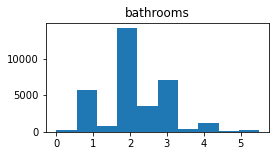

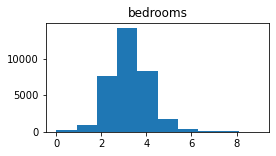

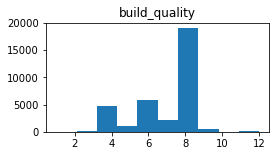

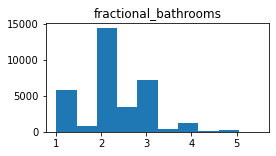

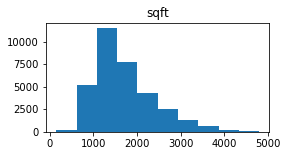

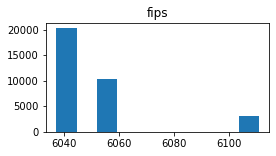

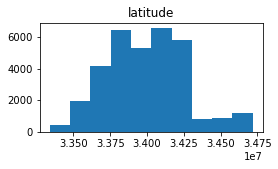

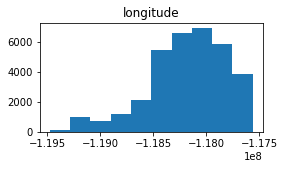

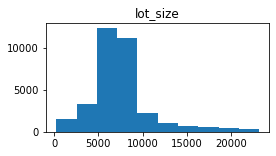

TypeError: '<=' not supported between instances of 'int' and 'str'

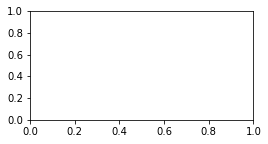

In [109]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33649 entries, 62513 to 40075
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   bathrooms                                   33649 non-null  float64
 1   bedrooms                                    33649 non-null  float64
 2   build_quality                               33649 non-null  float64
 3   fractional_bathrooms                        33649 non-null  float64
 4   sqft                                        33649 non-null  float64
 5   fips                                        33649 non-null  float64
 6   latitude                                    33649 non-null  float64
 7   longitude                                   33649 non-null  float64
 8   lot_size                                    33649 non-null  float64
 9   land_use_code                               33649 non-null  object 
 10  zoning

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'build_quality'}>,
        <AxesSubplot:title={'center':'fractional_bathrooms'}>,
        <AxesSubplot:title={'center':'sqft'}>,
        <AxesSubplot:title={'center':'fips'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'lot_size'}>,
        <AxesSubplot:title={'center':'city_id'}>,
        <AxesSubplot:title={'center':'units'}>,
        <AxesSubplot:title={'center':'structure_tax_value'}>],
       [<AxesSubplot:title={'center':'tax_value'}>,
        <AxesSubplot:title={'center':'land_tax_value'}>,
        <AxesSubplot:title={'center':'tax_amount'}>,
        <AxesSubplot:title={'center':'error'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'6059.0'}>],
       [<AxesSubplot:title={'center':'6111.0'}>,
        <Axes

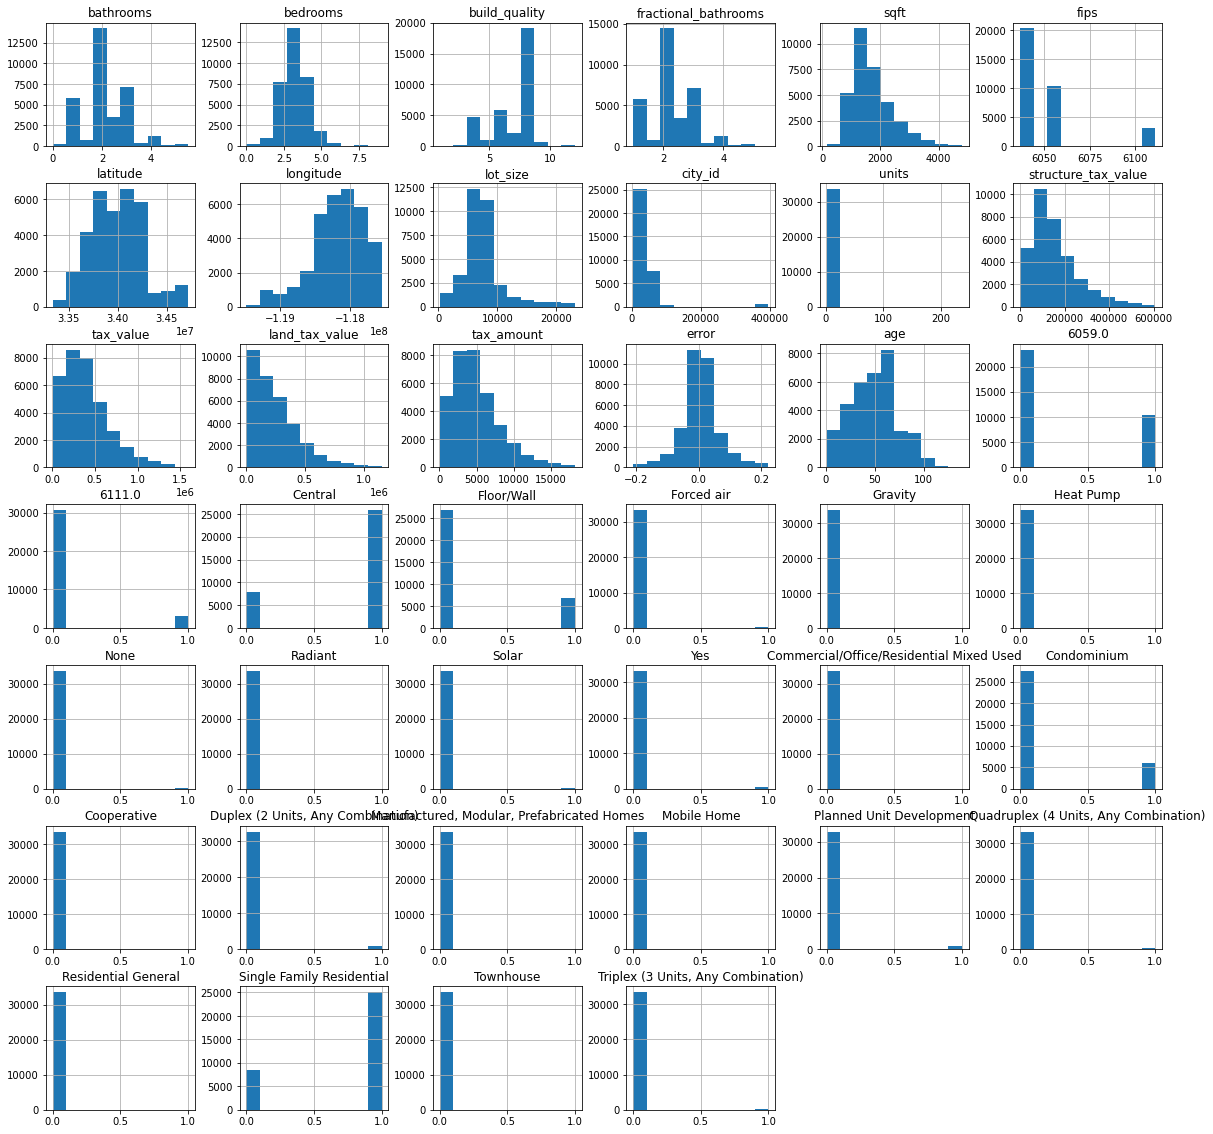

In [117]:
train.hist(figsize=[20,20])

In [118]:
train.shape, validate.shape, test.shape

((33649, 45), (14422, 45), (12018, 45))

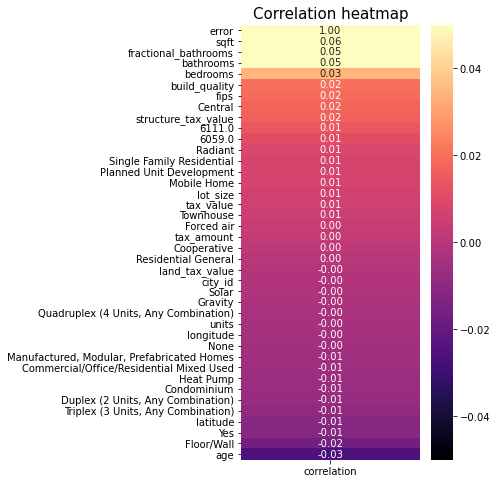

In [119]:
#correlation heatmap
corr = pd.DataFrame(train.corr()['error'].sort_values(ascending = False)).rename(columns = {'error':'correlation'})

plt.figure(figsize = (4,8))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'magma')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

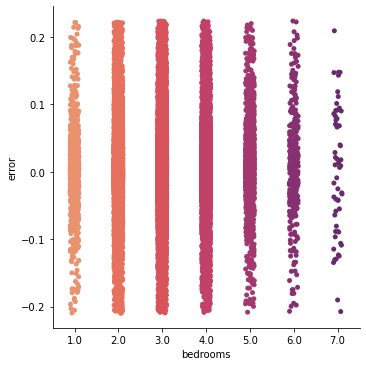

In [126]:
sns.catplot(data=train, x='bedrooms',y='error', palette='flare',order=[1.0,2.0,3.0,4.0,5.0,6.0,7.0])

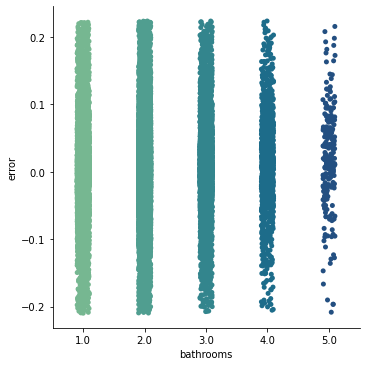

In [131]:
sns.catplot(data=train, x='bathrooms',y='error', palette='crest',order=[1.0,2.0,3.0,4.0,5.0,])

In [ ]:
sns.catplot(data=train, x='age',y='error', hue='age', palette='flare')

In [ ]:
train.info()